
# Select Data for Annotation

In [ ]:
! pip install boto3

In [1]:
import unidecode
import sys
sys.path.insert(0, '../util/')
import util_refactorings as ur
import util_data_access as uda
import util_data_fetching_for_app as udfa
import sqlite3
import pandas as pd 
import os 

if False:
    t = pd.read_sql('''SELECT 
                        name
                    FROM 
                        sqlite_master 
                    WHERE 
                        type ='table' AND 
                        name NOT LIKE 'sqlite_%';
    ''', con=conn)

In [2]:
source = 'nyt'

In [3]:
import glob
# files = glob.glob('../data/diffengine-diffs/spark-output/*')
files = glob.glob('../../news-edits-dbs/matched-sentences/*')

In [4]:
all_output = []

In [6]:
# files

In [7]:
for f in files[1:]:
    source = f.split('/')[-1].split('-')[0]
    print('doing %s' % source)
    if '.gz' in f:
        ! gunzip $f
        f = f.replace('.gz', '')

    conn = sqlite3.connect(f)
    matched_sentences, split_sentences = udfa.get_data_from_sqlite_by_sent_cutoffs(source, conn)
    output = udfa.match_sentences(matched_sentences, split_sentences)
    all_output.append(output)

    # zipping up again 
    ! gzip $f

doing nyt
doing ap
doing calgaryherald
doing independent
doing dailymail
doing nationalpost
doing cbc


DatabaseError: Execution failed on sql '
        with c1 as (
            SELECT entry_id, 
                    CAST(version as INT) as version, 
                    COUNT(1) as c from split_sentences 
                GROUP BY entry_id, version
        )
        SELECT entry_id, version from c1
        WHERE c < 15 and c > 3
    ': no such table: split_sentences

In [8]:
all_output_df = pd.concat(all_output)

In [ ]:
all_output_df = pd.read_pickle('cache/all-short-documents-eval-processed.pkl')

In [ ]:
ls ../mo

In [19]:
# all_output_df.to_pickle('cache/all-short-documents-eval-processed.pkl')

count_df = pd.read_csv('../modeling/data/training_data_short_15.csv.gz')

count_df = count_df.set_index(['source', 'entry_id', 'version'])

count_df_sums = (
    count_df
    .assign(num_sents=1)
    .assign(refactored_up=lambda df: (df['refactored_label'] < 0).astype(int))
    .assign(refactored_down=lambda df: (df['refactored_label'] > 0).astype(int))
    .drop(['sent_idx', 'sentence'], axis=1)
    .groupby(level=[0, 1, 2])
    .sum()
)

all_output_df_w_counts = pd.merge(
    left=count_df_sums.reset_index(),
    right=all_output_df.reset_index(),
    left_on=['source', 'entry_id', 'version'],
    right_on=['source', 'entry_id', 'version_x']
).set_index(['source', 'entry_id', 'version_x', 'version_y']).drop(['version'], axis=1)

all_output_df_w_counts = (all_output_df_w_counts
 .loc[lambda df: (df['num_sents'] > 5) & (df['num_sents'] < 10)]
)

all_output_df_w_counts['refactored_up'].value_counts()

all_output_df_w_counts['refactored_up'].value_counts()

add_above_weights = (
    all_output_df_w_counts['add_above_label']
    .value_counts()
    .sort_index()
    .pipe(lambda s: 1/s)
    .to_frame('add_weight')
    .reset_index()
)

delete_weights = (
    all_output_df_w_counts['deleted_label']
    .value_counts()
    .sort_index()
    .pipe(lambda s: 1/s)
    .to_frame('del_weight')
    .reset_index()

)

refactored_weights = (
    all_output_df_w_counts['refactored_up']
    .value_counts()
    .sort_index()
    .pipe(lambda s: 1/s)
    .to_frame('ref_weight')
    .reset_index()
)

source_weights = (
    all_output_df_w_counts
    .reset_index()
    ['source']
    .value_counts()
    .sort_index()
    .pipe(lambda s: 1/s)
    .to_frame('source_weight')
    .reset_index()
)

ref_multiplier = 7
t = (all_output_df_w_counts
     .reset_index()
     # downsample for refactoring 
     .merge(refactored_weights, left_on='refactored_up', right_on='index')
     .pipe(lambda df: df.sample(40000, weights=df['ref_weight']))
     # add_above_weights    
     .merge(add_above_weights, left_on='add_above_label', right_on='index')
     .assign(add_weight=lambda df: df.apply(lambda x: x['add_weight'] if x['refactored_up'] == 0 else x['add_weight'] * ref_multiplier, axis=1))
     .pipe(lambda df: df.sample(16000, weights=df['add_weight']))
     # delete weights
     .merge(delete_weights, left_on='deleted_label', right_on='index')
     .assign(del_weight=lambda df: df.apply(lambda x: x['del_weight'] if x['refactored_up'] == 0 else x['del_weight'] * ref_multiplier, axis=1))
     .pipe(lambda df: df.sample(3200, weights=df['del_weight']))
     #  source weights
     .merge(source_weights, left_on='source', right_on='index')
     .assign(source_weight=lambda df: df.apply(lambda x: x['source_weight'] if x['refactored_up'] == 0 else x['source_weight'] * ref_multiplier, axis=1))
     .pipe(lambda df: df.sample(400, weights=df['source_weight']))     
).set_index(['source', 'entry_id', 'version_x', 'version_y'])

In [65]:
t['refactored_up'].value_counts()

0    37576
1     2245
2      170
3        9
Name: refactored_up, dtype: int64

In [97]:
t['refactored_up'].value_counts()

1    214
0    172
2     13
3      1
Name: refactored_up, dtype: int64

In [98]:
t.reset_index('source')['source'].value_counts()

bbc            96
independent    69
wp             64
guardian       58
ap             54
nyt            37
reuters        22
Name: source, dtype: int64

In [19]:
## quick-n-dirty data
t = (all_output_df
     .loc[lambda df: df['nodes'].str.len() < 50]
     .loc[lambda df: df['arcs'].notnull()]
     .loc[lambda df: df['arcs'].str.len() > 4]
     .loc[lambda df: df['arcs'].str.len() > 10]
     .head(200)
)

output = t[['nodes', 'arcs']].to_dict(orient='index')
output = {str(k): v for k, v in output.items()}
import json
with open('../evaluation/data/data-downsampled.json', 'w') as f:
    json.dump(output, f )

In [99]:
output = t[['nodes', 'arcs']].to_dict(orient='index')
output = {str(k): v for k, v in output.items()}
import json
with open('../evaluation/data/data-downsampled.json', 'w') as f:
    json.dump(output, f )

In [77]:
! ls -lh ../evaluation/data/

total 30328
-rw-r--r--   1 alex  staff   1.8M Nov  4 23:26 data-downsampled.json
drwxr-xr-x  24 alex  staff   768B Oct 13 01:10 output_data
-rw-r--r--   1 alex  staff   5.0M Oct 31 20:26 sample_ap_data.json
-rw-r--r--   1 alex  staff    16K Sep 16 05:15 sample_datum.json
-rw-r--r--   1 alex  staff   343K Nov  3 18:13 sample_datum_corrections.json
-rw-r--r--   1 alex  staff   765K Sep 21 03:46 sample_datum_many.json
-rw-r--r--   1 alex  staff   6.4M Sep 22 01:22 sample_datum_many_sent_breaks.json


In [4]:
import json
with open('../evaluation/data/data-downsampled.json', 'r') as f:
    output = json.load(f)

# Checks

In [14]:
matched_sentences.head()

NameError: name 'matched_sentences' is not defined

In [16]:
null_sents = (
    matched_sentences
     .groupby(['entry_id', 'version_x', 'version_y'])
     [['sent_idx_x','sent_idx_y']]
    .apply(lambda df: df.isnull().sum())
    .rename(columns={'sent_idx_x': 'num_deleted', 'sent_idx_y': 'num_added'})
    #  .sort_values(ascending=False).loc[lambda s: s <4]
)

In [17]:
non_zero_sents = (
    matched_sentences
     .groupby(['entry_id', 'version_x', 'version_y'])
     [['avg_sentence_distance_x', 'avg_sentence_distance_y']]
     .mean()
)

In [18]:
doc_level_stats = pd.concat([
    null_sents, 
    non_zero_sents
], axis=1)

In [19]:
doc_level_stats.loc[lambda df: df['num_deleted'] == 3] ## choose all documents with 3 deletions
## num_deleted = number of deleted sentences 
## num_added = number of added sentences 
## avg_sentence_distance_x, avg_sentence_distance_y = overall, how different are the sentences across the document?



num_deleted  num_added  avg_sentence_distance_x  \
entry_id version_x version_y                                                    
4        27        28                   3          2                 0.178994   
27       8         9                    3          1                 0.241061   
95       1         2                    3          0                 0.213974   
         3         4                    3         11                 0.421040   
         19        20                   3          0                 0.064634   
...                                   ...        ...                      ...   
21614    0         1                    3          1                 0.315155   
22460    0         1                    3          0                 0.131347   
22864    0         1                    3          3                 0.093593   
23003    0         1                    3          3                 0.101784   
23078    0         1                    3          1                 0.074087   

                              avg_sentence_distance_y  
entry_id version_x version_y                           
4        27        28                        0.178994  
27       8         9                         0.241531  
95       1         2                         0.214219  
         3         4                         0.421040  
         19        20                        0.109541  
...                                               ...  
21614    0         1                         0.312595  
22460    0         1                         0.130701  
22864    0         1                         0.093939  
23003    0         1                         0.102017  
23078    0         1                         0.074087  

[399 rows x 4 columns]

In [20]:
doc_level_stats.loc[lambda df: df['avg_sentence_distance_x'] > 2e-01] ## choose all documents with 3 deletions

num_deleted  num_added  avg_sentence_distance_x  \
entry_id version_x version_y                                                    
4        12        13                   4          9                 0.241678   
         13        14                   7          4                 0.270817   
         21        22                   2          2                 0.237003   
         28        29                   4          5                 0.277796   
5        6         7                    5          4                 0.244841   
...                                   ...        ...                      ...   
22212    0         1                    9          0                 0.225256   
22614    0         1                    7          3                 0.320019   
22783    0         1                    8          4                 0.281086   
22914    0         1                    2          2                 0.260872   
22995    0         1                    6          6                 0.380042   

                              avg_sentence_distance_y  
entry_id version_x version_y                           
4        12        13                        0.290792  
         13        14                        0.270708  
         21        22                        0.237003  
         28        29                        0.277796  
5        6         7                         0.272071  
...                                               ...  
22212    0         1                         0.186219  
22614    0         1                         0.291688  
22783    0         1                         0.313712  
22914    0         1                         0.278024  
22995    0         1                         0.380042  

[1036 rows x 4 columns]

In [21]:
desired_index = doc_level_stats.loc[lambda df: df['avg_sentence_distance_x'] > 2e-01]

In [22]:
# x = 870103
# desired_index = list(filter(lambda x: x[0] == 870103, desired_index.index))

In [ ]:
# merge both
merged_matched_sentences = (matched_sentences
 .merge(
    split_sentences, left_on=['entry_id', 'version_x', 'sent_idx_x'], right_on=['entry_id', 'version', 'sent_idx'],
    how='left'
 ).drop(['version', 'sent_idx', 'key', 'key_x', 'key_y'], axis=1)
 .merge(
    split_sentences, left_on=['entry_id', 'version_y', 'sent_idx_y'], right_on=['entry_id', 'version', 'sent_idx'],
    how='left'
 ).drop(['version', 'sent_idx', 'key',], axis=1)
)

In [ ]:
# check how many additions there are
merged_matched_sentences.loc[lambda df: df['sent_idx_x'].isnull()]

# Launch to MTurk

In [5]:
from tqdm.auto import tqdm
import boto3
import os
from boto.mturk.connection import MTurkConnection
from boto.mturk.question import HTMLQuestion
import pandas as pd 
from boto.mturk.question import ExternalQuestion
from IPython.display import display, HTML
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from importlib import reload
from boto.mturk.qualification import (
    Qualifications,
    PercentAssignmentsApprovedRequirement, 
    NumberHitsApprovedRequirement
)

import sys
sys.path.insert(0, '../evaluation/')

import mturk as mturk
import mturk.utils_mturk as um

from importlib import reload
reload(um)
reload(mturk)

<module 'mturk' (namespace)>

In [6]:
print(os.environ['AWS_ACCESS_KEY_ID'])
print(os.environ['AWS_SECRET_ACCESS_KEY'])

VN2M29BH4PCAJT9ABZKN
O9bcBpaprrXr6Q3dorn0XYI4Kp8go6oBDBYFYqeD


In [7]:
from importlib import reload
reload(um)

env = 'sandbox'
# env = 'production'
mturk = um.MTurkHandler(environment=env) #=production/sandbox

In [43]:
CUSTOM_QUALIFICATION = True
# sandbox editor qualification: 3H3KEN1OLUQQR02IYZSVMYM7ESCBIO
sandbox_journalist_qual = mturk.create_qualification('journalist')
production_journalist_qual = mturk.create_qualification('journalist')

In [187]:
production_journalist_qual
# production editor qualification: 3YJP8DI8F7IJNZ5SWSN2GXBAZJF4Q2

{'QualificationType': {'QualificationTypeId': '3YJP8DI8F7IJNZ5SWSN2GXBAZJF4Q2',
  'CreationTime': datetime.datetime(2021, 11, 4, 23, 3, 23, tzinfo=tzlocal()),
  'Name': 'journalist',
  'Description': 'A custom qualification group given to workers we deem good.',
  'Keywords': 'custom-group filtering',
  'QualificationTypeStatus': 'Active',
  'IsRequestable': True,
  'AutoGranted': False},
 'ResponseMetadata': {'RequestId': '0edf8c83-69c6-446a-8d20-930712b2efa7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0edf8c83-69c6-446a-8d20-930712b2efa7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '315',
   'date': 'Fri, 05 Nov 2021 06:03:22 GMT'},
  'RetryAttempts': 0}}

In [149]:
sandbox_journalist_qual

{'QualificationType': {'QualificationTypeId': '3H3KEN1OLUQQR02IYZSVMYM7ESCBIO',
  'CreationTime': datetime.datetime(2021, 11, 4, 23, 0, 7, tzinfo=tzlocal()),
  'Name': 'journalist',
  'Description': 'A custom qualification group given to workers we deem good.',
  'Keywords': 'custom-group filtering',
  'QualificationTypeStatus': 'Active',
  'IsRequestable': True,
  'AutoGranted': False},
 'ResponseMetadata': {'RequestId': '28302a92-3fef-47d4-8f02-1b93f1e08258',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '28302a92-3fef-47d4-8f02-1b93f1e08258',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '315',
   'date': 'Fri, 05 Nov 2021 06:00:07 GMT'},
  'RetryAttempts': 0}}

In [159]:
casey = 'A17GX84A96WF6C'
jason = 'A2USH7VYFMU1ME'
roberto = 'A30BGCC8EC1NW'
meghan = 'A1685VEOIJIUMR'
alex = 'A2E8P5A3IKROKB'
meg = 'ASQL7ZBXI7WF6'
mturk.give_qualification_to_workers([
    casey,
    jason,
    roberto,
    meghan,
#     alex
], qualification_id='3YJP8DI8F7IJNZ5SWSN2GXBAZJF4Q2')

In [188]:
mturk.give_qualification_to_workers([meg], qualification_id='3YJP8DI8F7IJNZ5SWSN2GXBAZJF4Q2')

In [44]:
worker_requirements = [
    ### number of hits approved
    {
        'QualificationTypeId': '000000000000000000L0',
        'Comparator': 'GreaterThanOrEqualTo',
        'IntegerValues': [80],
    },
    ## worker local
    {
        'QualificationTypeId': '00000000000000000071',
        'Comparator': 'EqualTo',
        'LocaleValues': [{
            "Country":"US",
        }],
        'RequiredToPreview': True,
    },
    ## percent assignments approved
    {
        'QualificationTypeId': '000000000000000000L0',
        'Comparator': 'GreaterThanOrEqualTo',
        'IntegerValues': [90],
    },
]

## custom qualification
if CUSTOM_QUALIFICATION:
    worker_requirements = []
    if env == 'production':
        worker_requirements.append({
#             'QualificationTypeId': '3WZ6PU0JYXSTA4EIPF2M6S1CMZ7KL8',
            'QualificationTypeId': '3YJP8DI8F7IJNZ5SWSN2GXBAZJF4Q2', # journalists
            'Comparator': 'GreaterThanOrEqualTo',
            'IntegerValues': [90],      
        })
    else:
        worker_requirements.append({
#             'QualificationTypeId': '381R35RGJFFV6VLBBDX2MLZFNSH414',  ## UCLA students
            'QualificationTypeId': '3H3KEN1OLUQQR02IYZSVMYM7ESCBIO',  ## journalists
#             '3FQWXCP5BDC6A66PD20NE8FM4G3H44' other workers
            'Comparator': 'GreaterThanOrEqualTo',
            'IntegerValues': [90],      
        })

In [45]:
worker_requirements

[{'QualificationTypeId': '3H3KEN1OLUQQR02IYZSVMYM7ESCBIO',
  'Comparator': 'GreaterThanOrEqualTo',
  'IntegerValues': [90]}]

In [8]:
from jinja2 import Template, Environment, FileSystemLoader
import datetime
from IPython.display import display, HTML
jinja_env = Environment(loader=FileSystemLoader('../evaluation/templates'))

In [9]:
ls ../evaluation/templates/

check-matched-sentences-app-engine.html
check-matched-sentences.html
edit-sentences.html
match-sentences.html


In [10]:
template = jinja_env.get_template('match-sentences.html')
created_hits = []

In [11]:
import unidecode
def clean_temp(node):
    node['sentence'] = node['sentence'].replace('.p T', ' -- t')
    node['sentence'] = unidecode.unidecode(node['sentence'])
    return node
    
# data['nodes'] = list(map(clean_temp, data['nodes']))

In [12]:
output = {str(k): v for k, v in output.items()}

desired_keys = list(map(lambda x: str(tuple([source] + list(x))), desired_index.index))
desired_output = dict(list(filter(lambda x: x[0] in desired_keys, output.items())))

In [54]:
import json
with open('../evaluation/data/sample_ap_data.json', 'w') as f:
    json.dump( desired_output, f )

## Match Sentences HITs

In [23]:
# for i, idx in enumerate(desired_index.sample(10).index):
#     sample_key = str(tuple([source] + list(idx)))

i = 0
for sample_key, v in list(output.items())[:10]:
    source = 't'
    ## make the HTML 
    data = output[sample_key]
    html = template.render(
        data=data,
        doc_id=sample_key,
        source=source,
#         entry_id=idx[0],
#         v_x=idx[1],
#         v_y=idx[2],
        do_mturk=True,
        production=env=='production',
        start_time=datetime.datetime.now()
    )

    ## dump to disk for inspection
    with open('../evaluation/mturk/templated-question-example-%s.html' % i, 'w') as f:
        f.write(html)

    if False:
        ## HTMLQuestion HIT
        description = '''
            We\'d like to match sentences from two edited versions of the same article. 
            Help us by drawing lines to connect blocks of text.
        '''
        title = 'Edit some news articles v2'
        new_hit = mturk.client.create_hit(
            Title = title,
            Description = description,
            Keywords = 'text, highlighting',
            Reward = '0.4',
            MaxAssignments = 1,
            LifetimeInSeconds = 17280000,
            AssignmentDurationInSeconds = 600000,
            AutoApprovalDelayInSeconds = 28800,
            Question = html,
            QualificationRequirements=worker_requirements #if env == 'production' else []
        )
        created_hits.append(new_hit)

### Make Edits HITs

In [458]:
template = jinja_env.get_template('edit-sentences.html')
created_hits = []

In [461]:
env = 'sandbox'
# env = 'production'
mturk = um.MTurkHandler(environment=env) #=production/sandbox

In [462]:
to_launch = pd.DataFrame(output).T.iloc[250:300]

In [463]:
import ast
from tqdm.auto import tqdm

In [465]:
for i, idx in tqdm(enumerate(to_launch.index)):
    # filter data
    data = output[idx]
    key = ast.literal_eval(idx)
    versions = list(map(lambda x: x['version'], data['nodes']))
    x_vers = min(versions)
    data['nodes'] = list(filter(lambda x: x['version'] == x_vers, data['nodes']))
    
    ## make the HTML 
    html = template.render(
        data=data['nodes'],
        doc_id=key[1],
        source=key[0],
        entry_id=key[1],
        v_x=key[2],
        v_y=key[3],
        do_mturk=True,
        production=env=='production',
        start_time=datetime.datetime.now()
    )

    ## dump to disk for inspection
    with open('../evaluation/mturk/templated-question-example-%s.html' % i, 'w') as f:
        f.write(html)

    if True:
        ## HTMLQuestion HIT
        description = '''
            We\'d like to match sentences from two edited versions of the same article. 
            Help us by drawing lines to connect blocks of text.
        '''
        title = 'Edit some news articles v5'
        new_hit = mturk.client.create_hit(
            Title = title,
            Description = description,
            Keywords = 'text, highlighting',
            Reward = '1.00',
            MaxAssignments = 1,
            LifetimeInSeconds = 17280000,
            AssignmentDurationInSeconds = 600000,
            AutoApprovalDelayInSeconds = 28800,
            Question = html,
            QualificationRequirements=worker_requirements if env == 'production' else []
        )
        created_hits.append(new_hit)

0it [00:00, ?it/s]

In [174]:
import pickle
with open('hits_edits_cache/2021-11-04__first-round-production.pkl', 'wb') as f:
    pickle.dump(created_hits, f)

In [199]:
import pickle
with open('hits_edits_cache/2021-11-05__second-round-production.pkl', 'wb') as f:
    pickle.dump(created_hits, f)

In [62]:
import pickle
with open('hits_edits_cache/2021-11-05__third-round-sandbox.pkl', 'wb') as f:
    pickle.dump(created_hits, f)

# Fetch HITs

In [46]:
from importlib import reload
reload(um)

env = 'sandbox'
# env = 'production'
mturk = um.MTurkHandler(environment=env) #=production/sandbox

In [47]:
ls hits_edits_cache/

2021-10-31__first-round-sandbox.pkl
2021-10-31__second-round-sandbox.pkl
2021-11-04__first-round-production.pkl
2021-11-04__third-round-sandbox.pkl
2021-11-05__second-round-production.pkl
2021-11-05__third-round-sandbox.pkl


In [48]:
import pickle
# production
created_hits = []
with open('hits_edits_cache/2021-11-04__first-round-production.pkl', 'rb') as f:
    created_hits += pickle.load(f)
with open('hits_edits_cache/2021-11-05__second-round-production.pkl', 'rb') as f:
    created_hits += pickle.load(f)

# sandbox
if True:
    created_hits = []
    import pickle
    with open('hits_edits_cache/2021-11-05__third-round-sandbox.pkl', 'rb') as f:
        created_hits = pickle.load(f)

In [49]:
def get_answers(hit_ids):
    import xmltodict
    import json
    answer_dfs = []
    answers = []
    for hit_id in tqdm(hit_ids):
        try:
            ##
            assignmentsList = mturk.client.list_assignments_for_hit(
                HITId=hit_id,
                # AssignmentStatuses=['Submitted', 'Approved'],
                MaxResults=10
            )
            assignments = assignmentsList['Assignments']
            assignments_submitted_count = len(assignments)
        #     print(assignments_submitted_count)
        #     if assignments_submitted_count > 0:
        #         break 
            for assignment in assignments:
                # Retreive the attributes for each Assignment
                answer_dict = xmltodict.parse(assignment['Answer'])
                answer = json.loads(answer_dict['QuestionFormAnswers']['Answer'][1]['FreeText'])
                answer['worker_id'] = assignment['WorkerId']
                answer['assignment_id'] = assignment['AssignmentId']
                answer['hit_id'] = assignment['HITId']
                answer['time_delta'] = assignment['SubmitTime'] - assignment['AcceptTime']
                answer['submit_time'] = assignment['SubmitTime']
                answers.append(answer)
        except Exception as e:
            print(e)
    return answers

In [50]:
hit_ids = list(map(lambda x: x['HIT']['HITId'], created_hits))

In [51]:
len(hit_ids)

100

In [32]:
# answers, answer_df = mturk.get_answers_for_hit_list(set(hit_ids))
# t = 'A3PRQ2GSU42718'
# answer_df.loc[lambda df: df['worker_id'] == t]
# answer_df.drop_duplicates().to_csv('hits_cache/2021-10-24__all-answers-df.csv', index=False)
# with open('hits_cache/2021-10-24__all-answers.pkl', 'wb') as f :
#     pickle.dump(answers, f)
# answer_df.to_csv('hits_cache/2021-10-23__first-second-round-sandbox-results.csv')
# answer_df.to_csv('hits_cache/2021-10-23__third-fourth-round-sandbox-results.csv')
# answer_df.to_csv('hits_cache/2021-10-23__fifth-sixth-round-sandbox-results.csv')
# answer_df.to_csv('hits_cache/2021-10-23__seventh-eigth-round-sandbox-results.csv')
# answer_df.to_csv('hits_cache/2021-10-23__ninth-round-sandbox-results.csv')
# answer_df.to_csv('hits_cache/2021-10-23__tenth-round-sandbox-results.csv')
# answer_df['doc_id'].drop_duplicates()

In [52]:
answers = get_answers(hit_ids)

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
answer_df_s = pd.DataFrame(answers)

In [38]:
answer_df_p = pd.DataFrame(answers)

In [39]:
answer_df_p.to_pickle('hits_cache/production-hits.pkl')

In [428]:
answer_df = pd.read_pickle('hits_cache/2021-11-12__all-hits.pkl')

In [41]:
answer_df_t['worker_id'].value_counts()

ASQL7ZBXI7WF6     101
A2E8P5A3IKROKB     92
A17GX84A96WF6C     31
A1685VEOIJIUMR     13
A2USH7VYFMU1ME      5
A30BGCC8EC1NW       3
Name: worker_id, dtype: int64

In [40]:
# mturk.bonus_worker('ASQL7ZBXI7WF6', '3R8YZBNQ9LTQ6IYXXG9SVI6JZ7G7QI', 16)

In [ ]:
answer_df_t.loc[lambda df: df['worker_id'] == 'ASQL7ZBXI7WF6']

In [429]:
answer_df.to_pickle('hits_cache/2021-11-13__edit-answer-df.pkl')

In [416]:
answer_df_s.to_pickle('hits_cache/2021-11-12__all-hits.pkl')

In [54]:
## 2021-11-11 current
# answer_df.to_pickle('hits_cache/2021-11-12__edit-answer-df.pkl')
pd.concat([answer_df_p, answer_df_s]).to_pickle('hits_cache/2021-11-16__edit-answer-df.pkl')
# answer_df.to_pickle('hits_cache/2021-11-11__edit-answer-df.pkl')

In [26]:
answer_df_t = pd.concat([
    pd.read_pickle('hits_cache/2021-11-12__edit-answer-df.pkl'),
    pd.read_pickle('hits_cache/2021-11-13__edit-answer-df.pkl'),
])

In [55]:
answer_df_t = pd.read_pickle('hits_cache/2021-11-16__edit-answer-df.pkl')

In [58]:
## retrieve doc ids
import pickle
created_hits = []
with open('hits_edits_cache/2021-11-04__first-round-production.pkl', 'rb') as f:
    created_hits += pickle.load(f)
with open('hits_edits_cache/2021-11-05__second-round-production.pkl', 'rb') as f:
    created_hits += pickle.load(f)
with open('hits_edits_cache/2021-11-05__third-round-sandbox.pkl', 'rb') as f:
    created_hits += pickle.load(f)

In [59]:
import re
def retrieve_id(q):
    t = re.findall('source=(\w+)&doc_id=(\d+)&v_x=(\d+)&v_y=(\d+)', q)[-1]
    return (t[0], int(t[1]), int(t[2]), int(t[3]))

hit_ids = list(map(lambda x: x['HIT']['HITId'], created_hits))
doc_ids = list(map(lambda x: retrieve_id(x['HIT']['Question']), created_hits))

In [60]:
hit_id2doc_id_mapper = pd.DataFrame({'hit_ids':hit_ids, 'doc_ids': doc_ids})

In [61]:
hit_id2doc_id_mapper.head(2)

,hit_ids,doc_ids
0,3S829FDFU5BN942PK5240YGFBFXDXR,"(nyt, 810619, 0, 1)"
1,3OLZC0DJ9MPCDQDGC42X3AZ7N9XVI8,"(independent, 976785, 0, 1)"


In [62]:
import pandas as pd 
import sqlite3
import sys
sys.path.insert(0, '../util')
import util_refactorings as ur
from util_label import get_split_and_matched_dfs, label_sentences_add, get_sentence_and_doc_labels

In [63]:
answer_df_w_doc_id = (answer_df_t
 .merge(
     hit_id2doc_id_mapper,
     left_on=['hit_id'],
     right_on=['hit_ids']
 ).drop('hit_ids', axis=1)
 .assign(doc_id=lambda df: df['doc_ids']).drop('doc_ids', axis=1)
 
)

In [64]:
import ast
orig_output_df = (
    pd.DataFrame(output).T
    .reset_index().assign(index=lambda df: df['index'].apply(ast.literal_eval))
)

In [65]:
answer_df_w_orig_labels = (
    answer_df_w_doc_id
    .merge(orig_output_df, left_on=['doc_id'], right_on=['index'])
)

In [66]:
orig_output_df
answer_df_w_doc_id
answer_df_w_orig_labels.pipe(lambda df: df['nodes_x'] == df['nodes_y'])

0      False
1      False
2      False
3      False
4      False
       ...  
240    False
241    False
242    False
243    False
244    False
Length: 245, dtype: bool

In [67]:
import numpy as np
from tqdm.auto import tqdm

In [76]:
all_orig_sent_labels = []
all_orig_doc_labels = []
all_crowd_sent_labels = []
all_crowd_doc_labels = []

for idx in tqdm(range(len(answer_df_w_orig_labels))):
    df = answer_df_w_orig_labels.iloc[idx]

    ## orig data
    doc_sentences = df['nodes_y']
    x_ver = min(list(map(lambda x: x['version'], doc_sentences)))
    doc_sentences = list(filter(lambda x: x['version'] == x_ver, doc_sentences))
    doc_sents = pd.DataFrame(doc_sentences)
    doc_id = df['doc_id']
    e_id = doc_id[1]
    doc = pd.DataFrame(df['arcs'])
    doc['entry_id'] = e_id
    doc_sents['entry_id'] = e_id
    orig_sents, orig_doc = get_sentence_and_doc_labels(doc, doc_sents)

    ## crowd-sourced data
    t_answers = pd.DataFrame(df['final-list'])[['orig_sent_idx', 'new_sent_idx', 'is_edited']]
    t_answers = (t_answers
     .assign(orig_sent_idx=lambda df: df['orig_sent_idx'].replace('.textblock_pool', np.nan).replace('undefined', np.nan))
     .assign(new_sent_idx=lambda df: df['new_sent_idx'].replace('undefined', np.nan))
     .assign(avg_sentence_distance_x=lambda df: df['is_edited'].apply(lambda x: 1 if x else 0))
     .drop('is_edited', axis=1)
     .rename(columns={'orig_sent_idx': 'sent_idx_x', 'new_sent_idx': 'sent_idx_y'})
    )

    t_answers['entry_id'] = doc_id[1]
    t_answers['version_x'] = doc_id[2]
    t_answers['version_y'] = doc_id[3]
    t_answers= t_answers.astype(float)
    crowd_sents, crowd_doc = get_sentence_and_doc_labels(t_answers, doc_sents)
    crowd_sents['worker_id'] = df['worker_id']
    crowd_sents['assignment_id'] = df['assignment_id']
    crowd_sents['time_delta'] = df['time_delta']
    crowd_sents['submit_time'] = df['submit_time']
    crowd_doc['worker_id'] = df['worker_id']
    crowd_doc['assignment_id'] = df['assignment_id']
    crowd_doc['time_delta'] = df['time_delta']
    crowd_doc['submit_time'] = df['submit_time']
    
    all_orig_sent_labels.append(orig_sents)
    all_orig_doc_labels.append(orig_doc)
    all_crowd_sent_labels.append(crowd_sents)
    all_crowd_doc_labels.append(crowd_doc)

  0%|          | 0/245 [00:00<?, ?it/s]

In [78]:
all_orig_sent_labels_df = pd.concat(all_orig_sent_labels)
all_orig_doc_labels_df = pd.concat(all_orig_doc_labels)
all_crowd_sent_labels_df = pd.concat(all_crowd_sent_labels)
all_crowd_doc_labels_df = pd.concat(all_crowd_doc_labels)

In [79]:
all_orig_sent_labels_df.to_csv('../modeling/crowdworker-answers/orig-sent-labels-df.csv', index=False)
all_orig_doc_labels_df.to_csv('../modeling/crowdworker-answers/orig-doc-labels-df.csv', index=False)
all_crowd_sent_labels_df.to_csv('../modeling/crowdworker-answers/crowd-sent-labels-df.csv', index=False)
all_crowd_doc_labels_df.to_csv('../modeling/crowdworker-answers/crowd-doc-labels-df.csv', index=False)

In [83]:
all_crowd_doc_labels_df

,,num_deleted,num_added,num_edited,num_refactored,sentences,worker_id,assignment_id,time_delta,submit_time
entry_id,version,,,,,,,,,
810619,0,0,0,2,0,MOSCOW -- Malaysia Airlines reported Thursday ...,A1685VEOIJIUMR,3UN61F00H00BVFZEM2JV2O2S3UZR5D,0 days 00:01:25,2021-11-08 00:08:21-05:00
976785,0,1,2,2,0,A hotel in the Tunisian town of Sousse has bee...,A2USH7VYFMU1ME,3JRJSWSMQLWJ8W75MDB2OK5PA8DE3Q,0 days 00:03:05,2021-11-07 11:18:56-05:00
1548,4,0,0,4,0,"OAKLAND, N.J. (AP) -- A New Jersey branch of t...",A1685VEOIJIUMR,34QN5IT0T326I3YHQN7JUCBWWU108Q,0 days 00:01:20,2021-11-08 00:13:10-05:00
3571,14,0,3,4,0,SAN FRANCISCO (AP) -- Two people are criticall...,A17GX84A96WF6C,3WOKGM4L75R93VLXX4WFRY1WBTJO0J,0 days 00:01:34,2021-11-06 12:02:53-04:00
767,1,0,2,2,0,MOSCOW (AP) -- Russia's workhorse Proton-M roc...,A2USH7VYFMU1ME,3PM8NZGV82RKLX4OFTDQPHJ7061XQK,0 days 00:06:18,2021-11-07 11:11:04-05:00
...,...,...,...,...,...,...,...,...,...,...
959935,0,1,0,2,0,Users who search Google Maps for 'ham face Cam...,A2E8P5A3IKROKB,3HOSI13XH3ZCYIV2J759304C12ADDR,0 days 00:00:32,2021-11-13 21:07:11-05:00
403,0,3,9,0,0,ANKARA An unidentified gunman attacked police ...,A2E8P5A3IKROKB,3OS46CRSLJAZ7QG905XP3G0RKNJ6VJ,0 days 00:01:01,2021-11-09 14:15:25-05:00
23003,0,3,3,1,0,Final regular season NASCAR race delayed by ra...,A2E8P5A3IKROKB,3ERET4BTVQK89YOVZ8MULHGCUQSK9U,0 days 00:00:37,2021-11-13 21:02:07-05:00


In [82]:
all_orig_doc_labels_df

,,num_deleted,num_added,num_edited,num_refactored,sentences
entry_id,version,,,,,
810619,0,4,4,2,1,MOSCOW -- Malaysia Airlines reported Thursday ...
976785,0,2,5,4,1,A hotel in the Tunisian town of Sousse has bee...
1548,4,1,4,6,1,"OAKLAND, N.J. (AP) -- A New Jersey branch of t..."
3571,14,1,0,1,0,SAN FRANCISCO (AP) -- Two people are criticall...
767,1,6,0,0,0,MOSCOW (AP) -- Russia's workhorse Proton-M roc...
...,...,...,...,...,...,...
959935,0,1,0,2,2,Users who search Google Maps for 'ham face Cam...
403,0,3,6,5,0,ANKARA An unidentified gunman attacked police ...
23003,0,3,3,2,0,Final regular season NASCAR race delayed by ra...


# Analyze Answers (Current)

In [71]:
answer_df['worker_id'].value_counts()

A2E8P5A3IKROKB    56
A30BGCC8EC1NW      3
Name: worker_id, dtype: int64

In [ ]:
casey = 'A17GX84A96WF6C'
jason = 'A2USH7VYFMU1ME'
roberto = 'A30BGCC8EC1NW'
meghan = 'A1685VEOIJIUMR'
alex = 'A2E8P5A3IKROKB'
meg = 'ASQL7ZBXI7WF6'

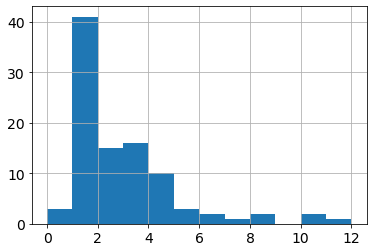

In [37]:
(answer_df['time_delta']
 .apply(lambda x: x.total_seconds())
 .pipe(lambda s: s/60)
 .hist(range=(0,12), bins=12)
)

In [40]:
answer_df.groupby('worker_id')['time_delta'].sum()

worker_id
A1685VEOIJIUMR   0 days 00:20:09
A17GX84A96WF6C   0 days 01:00:40
A2USH7VYFMU1ME   0 days 00:22:28
ASQL7ZBXI7WF6    0 days 23:20:25
Name: time_delta, dtype: timedelta64[ns]

In [231]:
for assignment in assignments:
    # Retreive the attributes for each Assignment
    answer_dict = xmltodict.parse(assignment['Answer'])
    answer = json.loads(answer_dict['QuestionFormAnswers']['Answer'][1]['FreeText'])

In [232]:
answer

{'doc_id': "('nyt', 752766, 1, 2)",
 'annotated connections': [],
 'nodes': [{'sent_idx': 0,
   'sentence': 'Crimea will vote on Sunday in a ballot referendum that leaders of the regional Parliament expect will ratify their decision to break away from Ukraine and become part of Russia.',
   'version': 1},
  {'sent_idx': 1,
   'sentence': 'The referendum will offer two choices, neither one of them “No”: 1) “Are you in favor of the reunification of Crimea with Russia as a part of the Russian Federation?” 2) “Are you in favor of restoring the 1992 Constitution and the status of Crimea as a part of Ukraine?” Voters will have to mark one option affirmatively, but they cannot vote for the status quo.',
   'version': 1},
  {'sent_idx': 2,
   'sentence': 'A return to the 1992 Constitution — adopted after the Soviet collapse but quickly thrown out by the post-Soviet Ukraine — would effectively provide for Crimea’s independence, while remaining part of Ukraine.',
   'version': 1},
  {'sent_idx':

In [282]:
hits = mturk.client.list_hits(MaxResults=100)

In [283]:
hits_df = pd.DataFrame(hits['HITs'])

In [284]:
hits_df['CreationTime'] = pd.to_datetime(hits_df['CreationTime'])
import datetime

In [285]:
hits_df['CreationTime']

0    2021-10-22 20:05:44-07:00
1    2021-10-22 20:05:43-07:00
2    2021-10-22 20:05:42-07:00
3    2021-10-22 20:05:41-07:00
4    2021-10-22 20:05:40-07:00
                ...           
93   2021-05-13 12:39:03-07:00
94   2021-05-13 12:39:03-07:00
95   2021-05-13 12:39:02-07:00
96   2021-05-13 12:39:01-07:00
97   2021-05-13 12:39:00-07:00
Name: CreationTime, Length: 98, dtype: datetime64[ns, tzlocal()]

In [260]:
hits_df.loc[lambda df: df['CreationTime']  > datetime.datetime(2021, 10, 1, tzinfo=datetime.tzinfo)]

TypeError: Cannot compare tz-naive and tz-aware datetime-like objects

In [181]:
from importlib import reload

In [183]:
reload(um)

<module 'mturk.utils_mturk' from '../evaluation/mturk/utils_mturk.py'>

In [92]:
list(filter(lambda x: x['version'] == 1 and x['sent_idx'] == 0, data['nodes']))

[{'version': 1,
  'sent_idx': 0,
  'sentence': 'TAIPEI, Taiwan — A man fatally stabbed six nurses and a manager on Thursday at a Chinese military hospital in a seaside area famous for gatherings of Communist Party leaders, police officials in China said.'}]

In [97]:
t1 = "TAIPEI, Taiwan — Police officials in China said Thursday that they arrested a man suspected of stabbing to death six nurses and a manager at a Chinese military sanitarium in a seaside area famous for gatherings of Communist Party leaders."
t2 = "TAIPEI, Taiwan — A man fatally stabbed six nurses and a manager on Thursday at a Chinese military hospital in a seaside area famous for gatherings of Communist Party leaders, police officials in China said."

t1 = 'ZABUL, Afghanistan — A complex attack on a military base in southern Afghanistan Monday left at least one member of U.S.-led coalition forces dead.'
t2 = 'ZABUL, Afghanistan — A complex attack on a military base in southern Afghanistan Monday killed at least one member of the U.S.-led coalition forces.'

In [98]:
import sys
sys.path.insert(0, '../')
import util.util_newssniffer_parsing as unp

In [99]:
unp.html_compare_sentences(t1, t2)

('ZABUL , Afghanistan — A complex attack on a military base in southern Afghanistan Monday <span style="background-color:rgba(255,0,0,0.3)">left</span>  at least one member of  U.S.-led coalition forces <span style="background-color:rgba(255,0,0,0.3)">dead</span> .',
 'ZABUL , Afghanistan — A complex attack on a military base in southern Afghanistan Monday  <span style="background-color:rgba(0,255,0,0.3)">killed </span> at least one member of <span style="background-color:rgba(0,255,0,0.3)">the </span> U.S.-led coalition forces  .')

In [101]:
t1= 'The police said the suspect in the killings Thursday morning in Beidaihe, a resort area in the Hebei Province city of Qinhuangdao, is a sanitarium employee, indicating the attack was likely not the result of a dispute over a patient’s treatment-- the suspect, a 27-year-old man, had no known conflict with the victims, who were killed in a women’s dormitory at the hospital, the Qinhuangdao City Public Security Bureau said in a statement online.'

t2 = 'The suspect, a 27-year-old hospital employee who had no known motive, was arrested after the attacks, the Qinhuangdao City Public Security Bureau said in a statement online.'
t3 = 'The stabbings took place Thursday morning in Beidaihe, a resort area in the Hebei Province city of Qinhuangdao, about 180 miles east of Beijing.'
t4 = 'But the fact that the suspect in the Beidaihe case is an employee indicates that the attack was probably not the result of a dispute over a patient’s treatment.'
t5 = 'The victims were killed in a women’s dormitory at the hospital for elderly military personnel, also known as People’s Liberation Army Hospital 281, the statement said.'

In [108]:
import pyperclip
pyperclip.copy(unp.html_compare_sentences(t1, t5)[1])